In [1]:
from flash_ansr import FlashANSRDataset, get_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
MODEL = 'v7.20.4'

In [3]:
dataset = FlashANSRDataset.from_config(get_path('configs', MODEL, 'dataset_train.yaml'))

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 26317.98it/s]


In [4]:
N_SAMPLES = 10_000

In [5]:
data_raw = [d for d in dataset.iterate(size=N_SAMPLES, verbose=True)]

Generating data: 100%|██████████| 10000/10000 [00:27<00:00, 363.43it/s, reject_rate=44.07%]


In [6]:
data = {k: [d[k] for d in data_raw] for k in data_raw[0].keys()}

In [7]:
data.keys()

dict_keys(['n_rejected', 'skeletons', 'skeleton_hashes', 'expressions', 'constants', 'input_ids', 'x_tensors', 'y_tensors'])

In [37]:
dataset.skeleton_pool.expression_space.prefix_to_infix(data['skeletons'][15])

'<num> + (x2 + (<num> + (<num> + (mult3(x1) + mult5(x3)))))'

In [38]:
dataset.expression_space.simplify(data['skeletons'][15])

['+',
 '<num>',
 '+',
 'x2',
 '+',
 '<num>',
 '+',
 '<num>',
 '+',
 'mult3',
 'x1',
 'mult5',
 'x3']

In [33]:
dataset.expression_space.simplification_rules[0]

(('neg', 'float("nan")'), ('float("nan")',))

In [39]:
data['skeletons'][15]

['+',
 '<num>',
 '+',
 'x2',
 '+',
 '<num>',
 '+',
 '<num>',
 '+',
 'mult3',
 'x1',
 'mult5',
 'x3']

In [9]:
data['skeletons'] = [[str(token) for token in d] for d in data['skeletons']]
data['expressions'] = [[str(token) for token in d] for d in data['expressions']]
data['constants'] = [[float(constant) for constant in d] for d in data['constants']]
data['lengths'] = np.array([len(s) for s in data['skeletons']])
data['n_support'] = np.array([len(s) for s in data['x_tensors']])
data['all_x'] = np.array([x.item() for x_tensor in tqdm(data['x_tensors']) for x in x_tensor.flatten()])
data['all_x'] = data['all_x'][data['all_x'] != 0]
data['all_y'] = np.array([y.item() for y_tensor in tqdm(data['y_tensors']) for y in y_tensor.flatten()])
data['all_constants'] = np.array([c for constants in tqdm(data['constants']) for c in constants])
data['n_constants'] = np.array([len(constants) for constants in data['constants']])
data['n_variables'] = np.array([len([t for t in s if t in dataset.skeleton_pool.expression_space.variables]) for s in data['skeletons']])

100%|██████████| 10000/10000 [00:00<00:00, 8511168.83it/s]


In [10]:
def format_int(x):
    if x < 1_000:
        return int(x)
    elif x < 1_000_000:
        return f'{int(x // 1_000)}k'
    else:
        return f'{int(x // 1_000_000)}M'

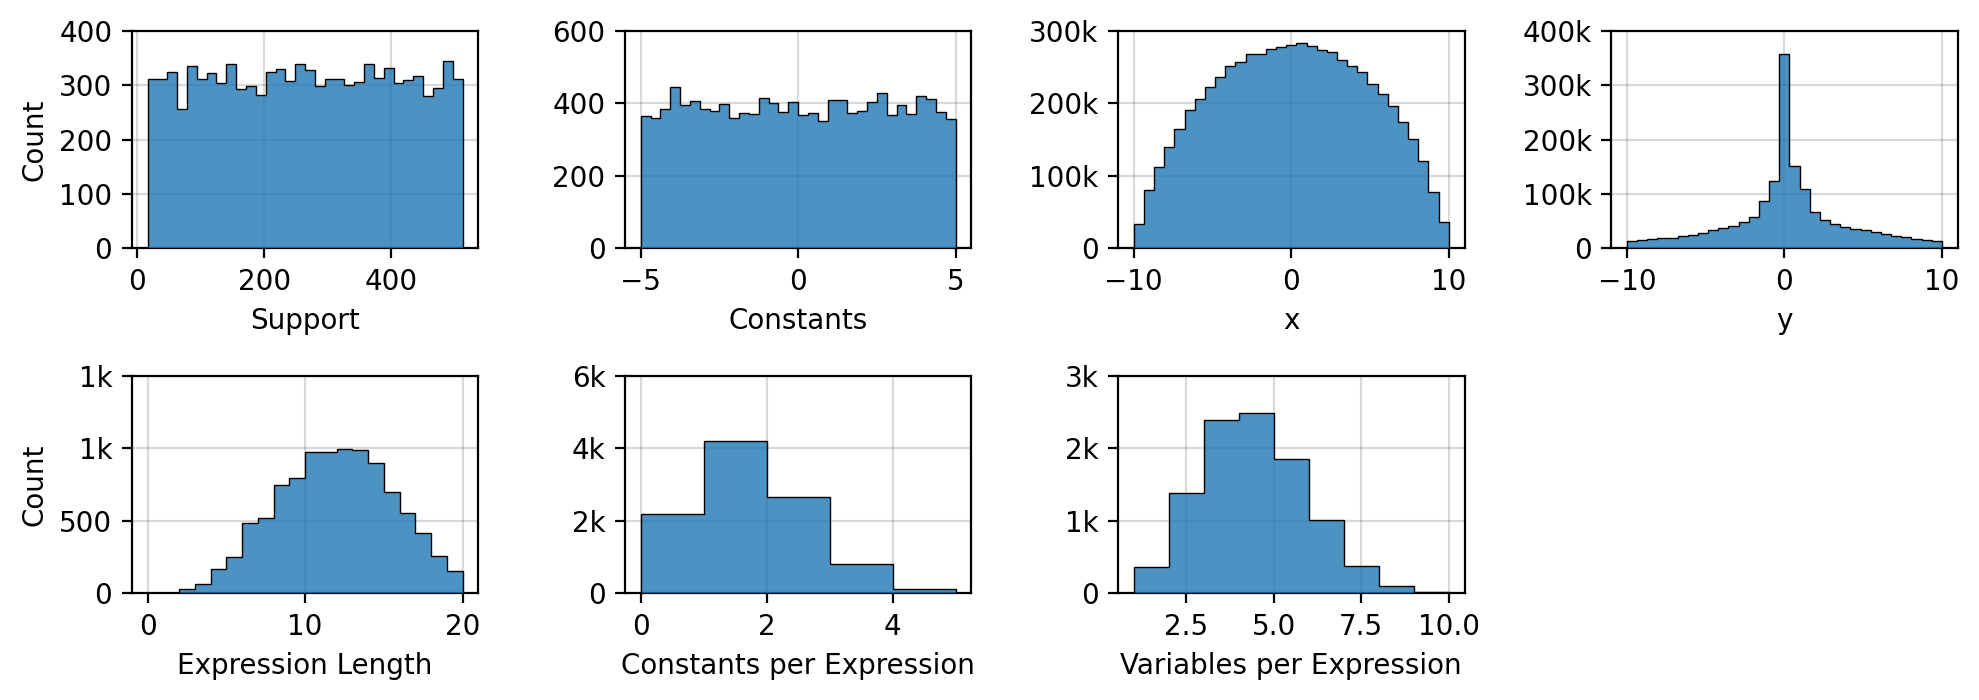

In [11]:
histogram_keys = ['n_support', 'all_constants', 'all_x', 'all_y', 'lengths', 'n_constants', 'n_variables']
titles = ['Support', 'Constants', 'x', 'y', 'Expression Length', 'Constants per Expression', 'Variables per Expression']
bins_list = [32, 32, np.linspace(-10, 10, 32), np.linspace(-10, 10, 32), np.arange(0, data['lengths'].max()), np.unique(data['n_constants']), np.unique(data['n_variables'])]

COLS = min(4, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.8), dpi=200)

for i, (ax, k, bins, title) in enumerate(zip(axes.flatten(), histogram_keys, bins_list, titles)):
    ax.hist(data[k], bins=bins, zorder=4, alpha=0.8, rasterized=True)
    ax.hist(data[k], bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5, rasterized=True)
    ax.set_xlabel(title)
    if i % COLS == 0:
        ax.set_ylabel('Count')
    ax.grid(alpha=0.15, color='k')
    # ax.set_xticks(np.arange(0, 20, 5));

    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([format_int(y) for y in ax.get_yticks()])

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=2)

plt.savefig(get_path('results', 'data_analysis', create=True, filename='data_histograms.svg'), bbox_inches='tight')

In [12]:
from scipy.stats import kstest
import scipy.stats as stats
from scipy.stats import ks_2samp

kstest(data['n_support'], stats.uniform(loc=16, scale=(512-16)).cdf)

KstestResult(statistic=np.float64(0.007645161290322555), pvalue=np.float64(0.6000162622153549), statistic_location=np.int64(211), statistic_sign=np.int8(-1))

In [13]:
kstest(data['all_constants'], stats.uniform(loc=-5, scale=10).cdf)

KstestResult(statistic=np.float64(0.005710071552760487), pvalue=np.float64(0.8105317830515919), statistic_location=np.float64(0.9237781167030334), statistic_sign=np.int8(-1))

In [14]:
# Test if the all_distribution is symmetric
negative_x = data['all_x'][data['all_x'] < 0]
positive_x = data['all_x'][data['all_x'] > 0]

ks_2samp(-negative_x, positive_x, alternative='two-sided', mode='auto')

KstestResult(statistic=np.float64(0.0071976698825867436), pvalue=np.float64(1.444052858779855e-71), statistic_location=np.float64(5.2036519050598145), statistic_sign=np.int8(1))

In [15]:
# Test if the all_distribution is symmetric
negative_y = data['all_y'][data['all_y'] < 0]
positive_y = data['all_y'][data['all_y'] > 0]

ks_2samp(-negative_y, positive_y, alternative='two-sided', mode='auto')

KstestResult(statistic=np.float64(0.014774342924091743), pvalue=np.float64(7.433280819468599e-125), statistic_location=np.float64(51.23210906982422), statistic_sign=np.int8(1))

In [16]:
operator_counts = {op: 0 for op in dataset.skeleton_pool.expression_space.operator_arity.keys()}
for skeleton in data['skeletons']:
    for token in skeleton:
        if token in dataset.skeleton_pool.expression_space.operator_arity.keys():
            operator_counts[token] += 1

In [17]:
variable_counts = {v: 0 for v in dataset.skeleton_pool.expression_space.variables}
for skeleton in data['skeletons']:
    for token in skeleton:
        if token in dataset.skeleton_pool.expression_space.variables:
            variable_counts[token] += 1
variable_counts

{'x1': 13157, 'x2': 13169, 'x3': 13004}

In [18]:
operators_total = sum(operator_counts.values())
normalized_operator_counts = {op: count / operators_total for op, count in operator_counts.items()}

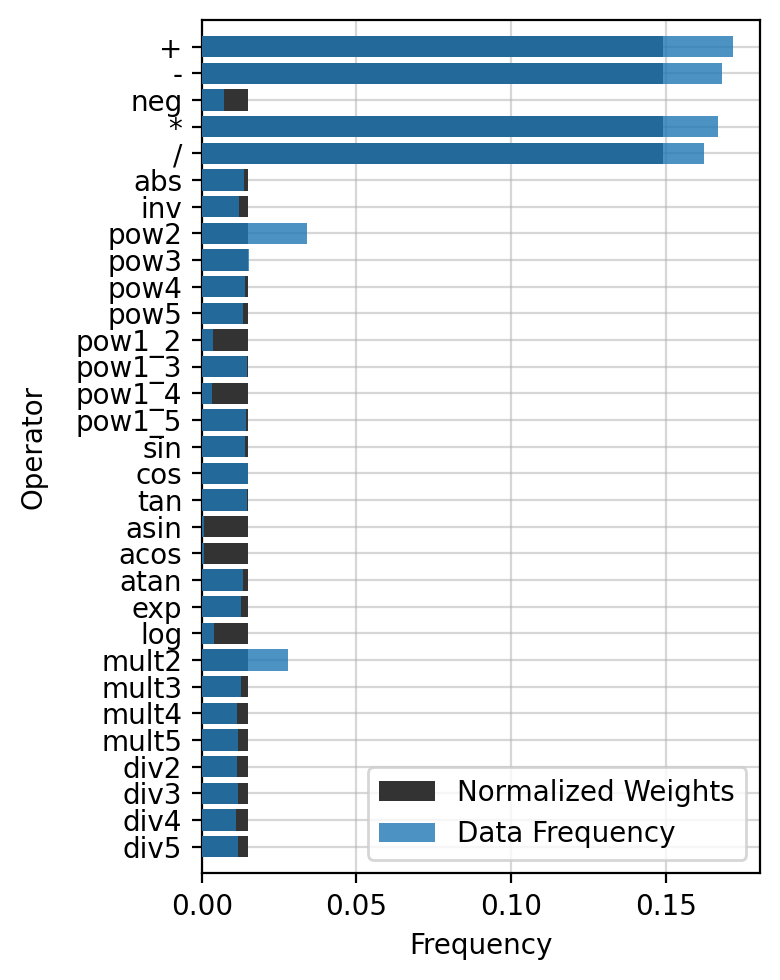

In [19]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=200)

ax.barh(dataset.skeleton_pool.expression_space.operator_weights.keys(), dataset.skeleton_pool.expression_space.operator_weights.values(), zorder=4, color='#333333', label='Normalized Weights', rasterized=True)
ax.barh(dataset.skeleton_pool.expression_space.operator_weights.keys(), [normalized_operator_counts[op] for op in dataset.skeleton_pool.expression_space.operator_weights.keys()], zorder=6, alpha=0.8, label='Data Frequency', rasterized=True)

ax.set_ylim(-1, len(dataset.skeleton_pool.expression_space.operator_weights))

ax.invert_yaxis()

ax.set_xlabel('Frequency')
ax.set_ylabel('Operator', labelpad=10)
ax.grid(alpha=0.5, zorder=1)

ax.legend()

fig.tight_layout()

plt.savefig(get_path('results', 'data_analysis', create=True, filename='train_operator_frequencies.svg'), bbox_inches='tight')

In [20]:
from collections import Counter

In [21]:
# Most common expressions
counter = Counter([tuple(s) for s in data['skeletons']])

In [22]:
# Note: various permutations of the same expressions may not be present due to filtering of held-out expressions
for expression, count in counter.most_common(10):
    print(f'{count:>3}: {dataset.skeleton_pool.expression_space.prefix_to_infix(expression)}')

  5: tan(x1)
  4: mult3(x2)
  4: div4(x1)
  3: <num> * tan(x1)
  3: div5(x3)
  3: mult4(x3)
  3: div3(x1)
  2: <num> + div2(x2)
  2: x3 * (mult2(x2) + (<num> * x1))
  2: (1/x1) - x3


In [23]:
one_dimensional_x = [np.array(x_tensor) for x_tensor, expression in zip(tqdm(data['x_tensors']), data['skeletons']) if len(set(t for t in expression if t in dataset.skeleton_pool.expression_space.variables)) == 1]
one_dimensional_x = [x[x != 0] for x in one_dimensional_x]

one_dimensional_y = [np.array(y_tensor)[:, 0] for y_tensor, expression in zip(tqdm(data['y_tensors']), data['skeletons']) if len(set(t for t in expression if t in dataset.skeleton_pool.expression_space.variables)) == 1]

# Flatten
one_dimensional_x = np.concatenate(one_dimensional_x)
one_dimensional_y = np.concatenate(one_dimensional_y)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_1416/2520161671.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  one_dimensional_x = [np.array(x_tensor) for x_tensor, expression in zip(tqdm(data['x_tensors']), data['skeletons']) if len(set(t for t in expression if t in dataset.skeleton_pool.expression_space.variables)) == 1]
  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_1416/2520161671.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  one_dimensional_y = [np.array(y_tensor)[:, 0] for y_tensor, expression in zip(tqdm(data['y_tensors']), data['skeletons']) if len(set(t for t in expression if t in dataset.skeleton_pool.expression_space.variables)) == 1]
100%|██████████| 10000/10000 [00:00<00:00, 327051.45it/s]


In [24]:
from matplotlib.colors import LogNorm

In [25]:
tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.5) + (1.0,)

(np.float64(0.133502), np.float64(0.002437), np.float64(0.1647075), 1.0)

/tmp/ipykernel_1416/3827421141.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


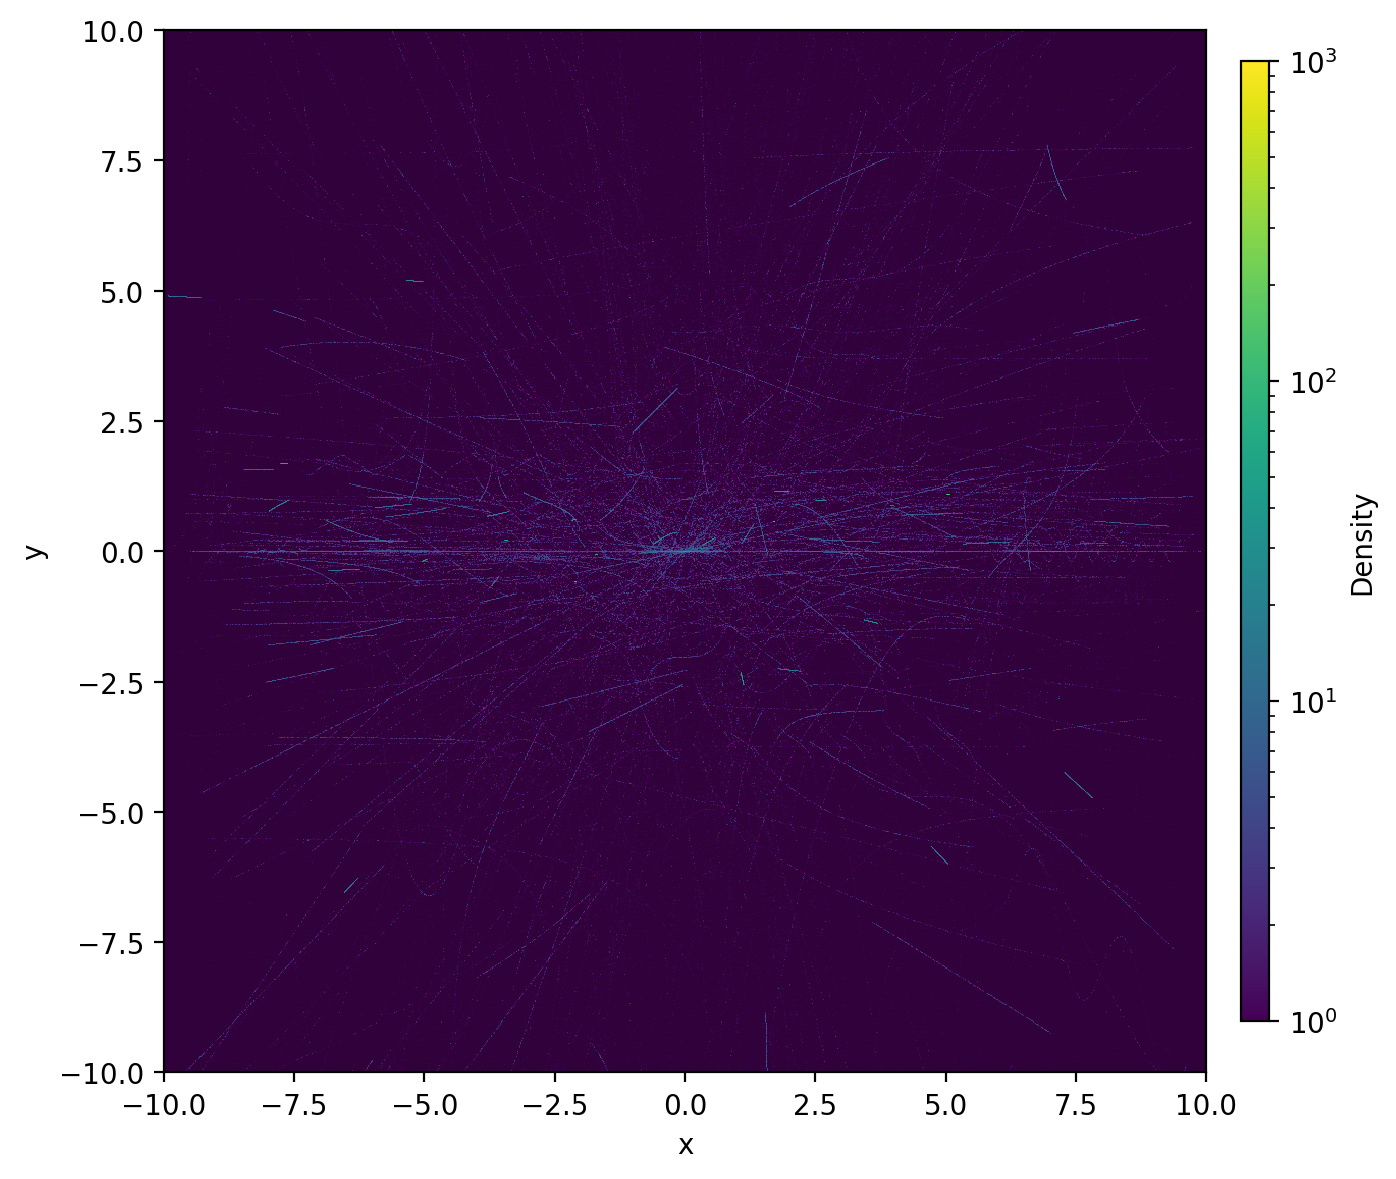

In [26]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)

# Change the fontsize
plt.rcParams.update({'font.size': 10})

res = 512
img = ax.hist2d(one_dimensional_x, one_dimensional_y, bins=(np.linspace(-10, 10, res*2), np.linspace(-10, 10, res*2)), norm=LogNorm(vmin=1, vmax=1e3), rasterized=True);
ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.7) + (1,))

ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.80])
fig.colorbar(img[3], cax=cbar_ax, label='Density')

fig.tight_layout()

plt.savefig(get_path('results', 'data_analysis', create=True, filename='1d_train_superimposed.svg'), bbox_inches='tight')